# Preprocessing of datasets

Attack traffic datasets (Booters) from https://ieeexplore.ieee.org/document/7140298/

Benign traffic datasets from http://mawi.wide.ad.jp/mawi/

We only show the procedure for one demo attack and one demo benign traffic dataset. The same procedure is applied to all the datasets we used for this project.

In [1]:
import pandas as pd
import hashlib
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

In [4]:
# load and show dataset
df1 = pd.read_csv("anon-Booter_dns1.pcap.csv", nrows=814919)
df1.head()

,frame.time_relative,ip.len,ip.src,ip.dst,udp.length,dns.id,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.z,dns.flags.authenticated,dns.flags.checkdisable,dns.flags.rcode,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dns.qry.class
0,0.000000,1054,107.87.219.23,227.213.154.241,1034.0,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
1,0.000085,1054,107.87.219.23,227.213.154.241,1034.0,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
2,0.000172,1054,107.87.219.23,227.213.154.241,1034.0,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
3,0.000259,1054,107.87.219.23,227.213.154.241,1034.0,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001
4,0.000347,1054,107.87.219.23,227.213.154.241,1034.0,0x0000c03b,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0,0x00000001


In [5]:
# load and show dataset
dfg = pd.read_csv("wideg_dns_cleared.csv", nrows=864272)
dfg.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,dst_AS,src_AS
0,87.0,210.166.249.129,133.91.254.11,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0,23623,7514
1,286.0,8.8.8.8,150.65.3.6,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0,17932,15169
2,135.0,8.8.8.8,203.178.130.217,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0,2500,15169
3,208.0,8.8.8.8,150.65.3.6,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0,17932,15169
4,232.0,203.178.141.194,157.7.180.137,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0,7506,2500


We first need to delete columns that do not exist in both datasets and reorder the rest columns of one dataset to match the order of the other.

In [6]:
df1_drop = df1.drop(columns=['frame.time_relative', 'dns.id', 'dns.flags.z', 'dns.flags.rcode', 'dns.qry.class'])
dfg_drop = dfg.drop(columns=['dst_AS', 'src_AS'])

In [7]:
df1_drop.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type
0,1054,107.87.219.23,227.213.154.241,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
1,1054,107.87.219.23,227.213.154.241,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
2,1054,107.87.219.23,227.213.154.241,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
3,1054,107.87.219.23,227.213.154.241,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0
4,1054,107.87.219.23,227.213.154.241,1034.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,14.0,13.0,23.0,<Root>,255.0


In [8]:
dfg_drop.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type
0,87.0,210.166.249.129,133.91.254.11,67.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,wa3.i-3-i.info,1.0
1,286.0,8.8.8.8,150.65.3.6,266.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,13.0,0.0,1.0,cnc.hub5pn.sandai.net,1.0
2,135.0,8.8.8.8,203.178.130.217,115.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7.3.215.95.in-addr.arpa,12.0
3,208.0,8.8.8.8,150.65.3.6,188.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,cncidx.m.hub.sandai.net,1.0
4,232.0,203.178.141.194,157.7.180.137,212.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,orange.kame.net,1.0


We drop samples with missing values.

In [9]:
df1_nan = df1_drop.dropna(axis=0)
dfg_nan = dfg_drop.dropna(axis=0)

We convert float numbers to integers.

In [10]:
df1_int = df1_nan.astype({'dns.flags.response':int, 'dns.flags.opcode':int, 'dns.flags.authoritative':int, 'dns.flags.truncated':int,
                          'dns.flags.recdesired':int, 'dns.flags.recavail':int, 'dns.flags.authenticated':int,
                          'dns.flags.checkdisable':int, 'dns.count.queries':int,
                          'dns.count.answers':int, 'dns.count.auth_rr':int, 'dns.count.add_rr':int, 'dns.qry.type':int})
dfg_int = dfg_nan.astype({'ip.len':int, 'udp.length':int, 'dns.flags.response':int, 'dns.flags.opcode':int,
                          'dns.flags.authoritative':int, 'dns.flags.truncated':int, 'dns.flags.recdesired':int, 'dns.flags.recavail':int,
                          'dns.flags.authenticated':int, 'dns.flags.checkdisable':int, 'dns.count.queries':int,
                          'dns.count.answers':int, 'dns.count.auth_rr':int, 'dns.count.add_rr':int, 'dns.qry.type':int})

In [11]:
df1_int.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type
0,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255
1,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255
2,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255
3,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255
4,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255


In [12]:
dfg_int.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type
0,87,210.166.249.129,133.91.254.11,67,1,0,1,0,0,0,0,0,1,1,0,1,wa3.i-3-i.info,1
1,286,8.8.8.8,150.65.3.6,266,1,0,0,0,1,1,0,1,1,13,0,1,cnc.hub5pn.sandai.net,1
2,135,8.8.8.8,203.178.130.217,115,1,0,0,0,1,1,0,0,1,0,1,0,7.3.215.95.in-addr.arpa,12
3,208,8.8.8.8,150.65.3.6,188,1,0,0,0,1,1,0,1,1,8,0,1,cncidx.m.hub.sandai.net,1
4,232,203.178.141.194,157.7.180.137,212,1,0,1,0,0,0,0,1,1,1,2,5,orange.kame.net,1


We add a column for the target, i.e. 0 for benign traffic and 1 for attack traffic.

In [13]:
df1_target = df1_int.assign(target = [1 for i in range(len(df1_int))])
df1_target.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255,1
1,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255,1
2,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255,1
3,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255,1
4,1054,107.87.219.23,227.213.154.241,1034.0,1,0,0,0,1,1,0,0,1,14,13,23,<Root>,255,1


In [14]:
dfg_target = dfg_int.assign(target = [0 for i in range(len(dfg_int))])
dfg_target.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,87,210.166.249.129,133.91.254.11,67,1,0,1,0,0,0,0,0,1,1,0,1,wa3.i-3-i.info,1,0
1,286,8.8.8.8,150.65.3.6,266,1,0,0,0,1,1,0,1,1,13,0,1,cnc.hub5pn.sandai.net,1,0
2,135,8.8.8.8,203.178.130.217,115,1,0,0,0,1,1,0,0,1,0,1,0,7.3.215.95.in-addr.arpa,12,0
3,208,8.8.8.8,150.65.3.6,188,1,0,0,0,1,1,0,1,1,8,0,1,cncidx.m.hub.sandai.net,1,0
4,232,203.178.141.194,157.7.180.137,212,1,0,1,0,0,0,0,1,1,1,2,5,orange.kame.net,1,0


We notice that dns query name and dns query type are nominal categorical features (the same holds for source and destination ip as well, but we will drop them later anyway). We will transform the former to a numerical value via hash encoding. As the latter is concerned, we could use one-hot encoding, but that would add 255 columns to the dataset. Instead, we observe that most of the samples of the Booters datasets use dns ANY type queries to perform the attacks, since bigger amplification factor is achieved this way. On the contrary, this seems to be a rather rare type query for benign traffic. So, we change this feature to binary, setting value 1 for ANY type and 0 for other types.

**Note:** Transforming dns query name to number is theoretically wrong in machine learning, because some order of the values of this feature is supposed, without such existing. However, due to the fact that some names appear in high frequence in attack traffic (e.g. DNS root zone), after testing in practice, it was found that this transformation slightly improves the results of the classifier, compared to dropping the column. Since, no encoding for nominal features with unknown number of classes seems to be applicable here (or to exist whatsoever), we decided to continue with this transformation. 

In [ ]:
df1_target['dns.qry.name'] = df1_target['dns.qry.name'].apply(lambda a: int(hashlib.sha256(a.encode('utf-8')).hexdigest(), 16) % 10**10)
dfg_target['dns.qry.name'] = dfg_target['dns.qry.name'].apply(lambda a: int(hashlib.sha256(a.encode('utf-8')).hexdigest(), 16) % 10**10)

df1_target['dns.qry.type'] = df1_target['dns.qry.type'].apply(lambda a: 1 if a == 255 else 0)
dfg_target['dns.qry.type'] = dfg_target['dns.qry.type'].apply(lambda a: 1 if a == 255 else 0)

In [ ]:
df1_target.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054,107.87.219.23,227.213.154.241,1034,1,0,0,0,1,1,0,0,1,14,13,23,661960001,1,1
1,1054,107.87.219.23,227.213.154.241,1034,1,0,0,0,1,1,0,0,1,14,13,23,661960001,1,1
2,1054,107.87.219.23,227.213.154.241,1034,1,0,0,0,1,1,0,0,1,14,13,23,661960001,1,1
3,1054,107.87.219.23,227.213.154.241,1034,1,0,0,0,1,1,0,0,1,14,13,23,661960001,1,1
4,1054,107.87.219.23,227.213.154.241,1034,1,0,0,0,1,1,0,0,1,14,13,23,661960001,1,1


In [ ]:
dfg_target.head()

,ip.len,ip.src,ip.dst,udp.length,dns.flags.response,dns.flags.opcode,dns.flags.authoritative,dns.flags.truncated,dns.flags.recdesired,dns.flags.recavail,dns.flags.authenticated,dns.flags.checkdisable,dns.count.queries,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,87,210.166.249.129,133.91.254.11,67,1,0,1,0,0,0,0,0,1,1,0,1,5270141173,0,0
1,286,8.8.8.8,150.65.3.6,266,1,0,0,0,1,1,0,1,1,13,0,1,8160770939,0,0
2,135,8.8.8.8,203.178.130.217,115,1,0,0,0,1,1,0,0,1,0,1,0,3091479927,0,0
3,208,8.8.8.8,150.65.3.6,188,1,0,0,0,1,1,0,1,1,8,0,1,4434701380,0,0
4,232,203.178.141.194,157.7.180.137,212,1,0,1,0,0,0,0,1,1,1,2,5,5328816654,0,0


Now we need to think logically and try some simple printing of values to decide that some features do not really contribute to distinguishing attack and benign traffic in general case, either because they are too specific (e.g. ip source and destination) or because they have the same value in almost all the samples (e.g. dns flag opcode). Thus, we drop these features as well. 

In [ ]:
df1_features = df1_target.drop(columns=['ip.src', 'ip.dst', 'dns.flags.response', 'dns.flags.opcode', 'dns.count.queries',
                                        'dns.flags.authenticated', 'dns.flags.truncated'])
dfg_features = dfg_target.drop(columns=['ip.src', 'ip.dst', 'dns.flags.response', 'dns.flags.opcode', 'dns.count.queries',
                                        'dns.flags.authenticated', 'dns.flags.truncated'])

In [ ]:
df1_features.head()

,ip.len,udp.length,dns.flags.authoritative,dns.flags.recdesired,dns.flags.recavail,dns.flags.checkdisable,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,1054,1034,0,1,1,0,14,13,23,661960001,1,1
1,1054,1034,0,1,1,0,14,13,23,661960001,1,1
2,1054,1034,0,1,1,0,14,13,23,661960001,1,1
3,1054,1034,0,1,1,0,14,13,23,661960001,1,1
4,1054,1034,0,1,1,0,14,13,23,661960001,1,1


In [ ]:
dfg_features.head()

,ip.len,udp.length,dns.flags.authoritative,dns.flags.recdesired,dns.flags.recavail,dns.flags.checkdisable,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,87,67,1,0,0,0,1,0,1,5270141173,0,0
1,286,266,0,1,1,1,13,0,1,8160770939,0,0
2,135,115,0,1,1,0,0,1,0,3091479927,0,0
3,208,188,0,1,1,1,8,0,1,4434701380,0,0
4,232,212,1,0,0,1,1,2,5,5328816654,0,0


We will perform a feature selection technique to further reduce the feature set. We will use random forest to do so.

In [ ]:
concatenated = pd.concat([df1_features, dfg_features], ignore_index=True)
concatenated = concatenated.sample(frac=1).reset_index(drop=True)

Feature: 0, Score: 0.03421
Feature: 1, Score: 0.06165
Feature: 2, Score: 0.00330
Feature: 3, Score: 0.02443
Feature: 4, Score: 0.00352
Feature: 5, Score: 0.00241
Feature: 6, Score: 0.08626
Feature: 7, Score: 0.12070
Feature: 8, Score: 0.04163
Feature: 9, Score: 0.23997
Feature: 10, Score: 0.38192


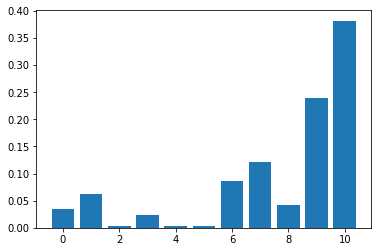

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(concatenated.iloc[:,:11], concatenated.iloc[:,11])
importance = rfc.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

We get the final dataset.

In [ ]:
final = concatenated.drop(columns=['dns.flags.authoritative', 'dns.flags.recavail', 'dns.flags.checkdisable'])
final

,ip.len,udp.length,dns.flags.recdesired,dns.count.answers,dns.count.auth_rr,dns.count.add_rr,dns.qry.name,dns.qry.type,target
0,133,113,0,0,1,1,7776286037,0,0
1,97,77,0,0,0,1,9890131421,0,0
2,149,129,0,0,1,1,5106278983,0,0
3,1500,2139,1,21,13,23,661960001,1,1
4,1054,1034,1,14,13,23,661960001,1,1
...,...,...,...,...,...,...,...,...,...
1678847,1054,1034,1,14,13,23,661960001,1,1
1678848,186,166,0,1,3,1,7577083056,0,0
1678849,72,52,0,0,0,0,506880779,0,0
1678850,98,78,0,1,0,0,5217094599,0,0


The same process is applied to the whole parts of all datasets used for the project. Then, the datasets that come off are propely distributed to clients and feed the neural networks.

**Note:** There is one last preprocessing step before the data can be used by the neural network. This is scaling and normalization of values, which is very important to make our model work. However, this step has to be applied after we split the data to training and test set.